Receiver operating-characteristic (ROC) curve is a popular graphical method frequently used in order to study the diagnostic capacity of continuous (bio)markers. When the considered outcome is a time-dependent variable, the direct generalization is known as cumulative/dynamic ROC curve. For a fixed point of time, t, one subject is allocated into the positive group if the event happens before t and into the negative group if the event is not happened at t. The presence of censored subject, which can not be directly assigned into a group, is the main handicap of this approach. The proposed cumulative/dynamic ROC curve estimator assigns a probability to belong to the negative (positive) group to the subjects censored previously to t. 

In [4]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd

from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split

from sksurv.datasets import load_flchain
from sksurv.linear_model import CoxPHSurvivalAnalysis
from sksurv.preprocessing import OneHotEncoder
from sksurv.util import Surv
from sksurv.metrics import (concordance_index_censored,
                            concordance_index_ipcw,
                            cumulative_dynamic_auc)

plt.rcParams['figure.figsize'] = [7.2, 4.8]

In [5]:
x, y = load_flchain()

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)

In [6]:
num_columns = ['age', 'creatinine', 'kappa', 'lambda']

imputer = SimpleImputer().fit(x_train.loc[:, num_columns])
x_train = imputer.transform(x_train.loc[:, num_columns])
x_test = imputer.transform(x_test.loc[:, num_columns])

we need to be a little bit careful when selecting the test data and time points we want to evaluate the ROC at, due to the estimator's dependence on inverse probability of censoring weighting. First, we are going to check whether the observed time of the test data lies within the observed time range of the training data.

In [7]:
y_events = y_train[y_train['death']]
train_min, train_max = y_events["futime"].min(), y_events["futime"].max()

y_events = y_test[y_test['death']]
test_min, test_max = y_events["futime"].min(), y_events["futime"].max()

assert train_min <= test_min < test_max < train_max, \
    "time range or test data is not within time range of training data."

When choosing the time points to evaluate the ROC at, it is important to remember to choose the last time point such that the probability of being censored after the last time point is non-zero. In the simulation study above, we set the upper bound to the maximum event time, here we use a more conservative approach by setting the upper bound to the 80% percentile of observed time points, because the censoring rate is quite large at 72.5%.

In [8]:
times = np.percentile(y["futime"], np.linspace(5, 81, 15))
print(times)

[ 470.3        1259.         1998.         2464.82428571 2979.
 3401.         3787.99857143 4051.         4249.         4410.17285714
 4543.         4631.         4695.         4781.         4844.        ]


We begin by considering individual real-valued features as risk scores without actually fitting a survival model. Hence, we obtain an estimate of how well age, creatinine, kappa FLC, and lambda FLC are able to distinguish cases from controls at each time point.

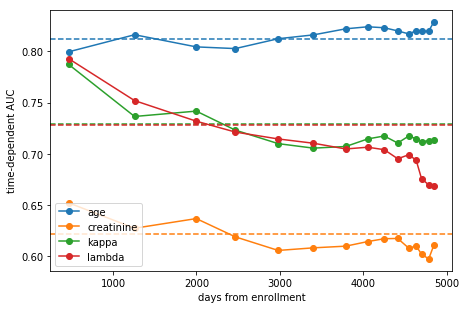

In [9]:
def plot_cumulative_dynamic_auc(risk_score, label, color=None):
    auc, mean_auc = cumulative_dynamic_auc(y_train, y_test, risk_score, times)

    plt.plot(times, auc, marker="o", color=color, label=label)
    plt.xlabel("days from enrollment")
    plt.ylabel("time-dependent AUC")
    plt.axhline(mean_auc, color=color, linestyle="--")
    plt.legend()

    
for i, col in enumerate(num_columns):
    plot_cumulative_dynamic_auc(x_test[:, i], col, color="C{}".format(i))
    ret = concordance_index_ipcw(y_train, y_test, x_test[:, i], tau=times[-1])

The plot shows the estimated area under the time-dependent ROC at each time point and the average across all time points as dashed line.
We can see that age is overall the most discriminative feature, followed by  and  FLC. That fact that age is the strongest predictor of overall survival in the general population is hardly surprising (we have to die at some point after all). More differences become evident when considering time: the discriminative power of FLC decreases at later time points, while that of age increases. The observation for age again follows common sense. In contrast, FLC seems to be a good predictor of death in the near future, but not so much if it occurs decades later.